In [1]:
# Import our dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Fix a random seed so the data can be reproduced
np.random.seed(24)

# Upload and read the csv files
ais_df = pd.read_csv("ml_data_daily_2018.csv", index_col=0)

In [2]:
# Look at our data
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
2018/01/01,9,37,145,44,27,13,12,7
2018/01/02,13,45,119,41,27,14,19,10
2018/01/03,13,44,106,40,36,14,20,11
2018/01/04,15,44,103,45,30,10,15,12
2018/01/05,10,45,107,41,26,13,21,10


In [3]:
# Creating a total column for our data
ais_df['Total']= ais_df.sum(numeric_only=True, axis=1)
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable,Total
2018/01/01,9,37,145,44,27,13,12,7,294
2018/01/02,13,45,119,41,27,14,19,10,288
2018/01/03,13,44,106,40,36,14,20,11,284
2018/01/04,15,44,103,45,30,10,15,12,274
2018/01/05,10,45,107,41,26,13,21,10,273


In [4]:
# And then check the type
ais_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2018/01/01 to 2018/12/31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fishing       365 non-null    int64
 1   TugTow        365 non-null    int64
 2   Recreational  365 non-null    int64
 3   Passenger     365 non-null    int64
 4   Cargo         365 non-null    int64
 5   Tanker        365 non-null    int64
 6   Other         365 non-null    int64
 7   Unavailable   365 non-null    int64
 8   Total         365 non-null    int64
dtypes: int64(9)
memory usage: 28.5+ KB


In [5]:
# Create nine DataFrames, each with the Date and one unique column:

# Fishing
ais_fishing_df = ais_df.loc[:, ['Fishing']]

# TugTow
ais_tugtow_df = ais_df.loc[:, ['TugTow']]

# Recreational
ais_recreational_df = ais_df.loc[:, ['Recreational']]

# Passenger
ais_passenger_df = ais_df.loc[:, ['Passenger']]

# Cargo
ais_cargo_df = ais_df.loc[:, ['Cargo']]

# Tanker
ais_tanker_df = ais_df.loc[:, ['Tanker']]

# Other
ais_other_df = ais_df.loc[:, ['Other']]

# Unavailable
ais_unavailable_df = ais_df.loc[:, ['Unavailable']]

# Total
ais_total_df = ais_df.loc[:, ['Total']]

In [6]:
# We will be using 'Total' as an example, and repeating the code for the rest of the data

# Check the new DataFrame
ais_total_df

,Total
2018/01/01,294
2018/01/02,288
2018/01/03,284
2018/01/04,274
2018/01/05,273
...,...
2018/12/27,298
2018/12/28,298
2018/12/29,306
2018/12/30,308


In [7]:
# From here, the code is heavily inspired by the code found on this site:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [8]:
# Convert the DataFrame into an array, and change the type to floats for the Neural Network
total = ais_total_df.values
total = total.astype('float32')

In [9]:
# Normalize the data by using a scaler
scaler = MinMaxScaler(feature_range=(0, 1))
total = scaler.fit_transform(total)

In [10]:
# Split our data into training and testing using slicing, and check the length

train_size = int(len(total) * 0.67)
#test_size = len(total) - train_size
train, test = total[train_size,:], total[:train_size]
print(len(train), len(test))

244 121


In [11]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# Reshape the values into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
# Reshape the data to incorperate into the LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
242/242 - 1s - loss: 0.0915 - 1s/epoch - 6ms/step
Epoch 2/100
242/242 - 0s - loss: 0.0190 - 368ms/epoch - 2ms/step
Epoch 3/100
242/242 - 0s - loss: 0.0164 - 355ms/epoch - 1ms/step
Epoch 4/100
242/242 - 0s - loss: 0.0150 - 360ms/epoch - 1ms/step
Epoch 5/100
242/242 - 0s - loss: 0.0137 - 477ms/epoch - 2ms/step
Epoch 6/100
242/242 - 0s - loss: 0.0124 - 365ms/epoch - 2ms/step
Epoch 7/100
242/242 - 0s - loss: 0.0114 - 367ms/epoch - 2ms/step
Epoch 8/100
242/242 - 0s - loss: 0.0108 - 367ms/epoch - 2ms/step
Epoch 9/100
242/242 - 0s - loss: 0.0102 - 365ms/epoch - 2ms/step
Epoch 10/100
242/242 - 0s - loss: 0.0098 - 355ms/epoch - 1ms/step
Epoch 11/100
242/242 - 0s - loss: 0.0095 - 358ms/epoch - 1ms/step
Epoch 12/100
242/242 - 0s - loss: 0.0093 - 368ms/epoch - 2ms/step
Epoch 13/100
242/242 - 0s - loss: 0.0092 - 400ms/epoch - 2ms/step
Epoch 14/100
242/242 - 0s - loss: 0.0090 - 357ms/epoch - 1ms/step
Epoch 15/100
242/242 - 0s - loss: 0.0092 - 360ms/epoch - 1ms/step
Epoch 16/100
242/242 -

In [15]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

4/4 [==============================] - 0s 2ms/step


In [16]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [17]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.42 RMSE
Test Score: 21.45 RMSE


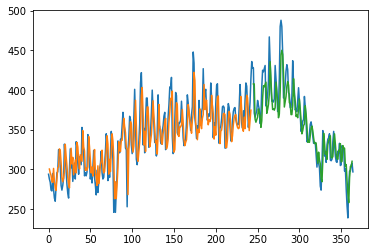

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(total)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(total)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(total)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(total))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()